In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from NiaPy.algorithms import BasicStatistics
from NiaPy.algorithms.basic import FishSchoolSearch
from NiaPy.algorithms.basic import ParticleSwarmAlgorithm
from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.benchmarks import Benchmark
from scipy.optimize import OptimizeResult
from scipy.optimize import rosen, minimize
from scipy.interpolate import Rbf

ModuleNotFoundError: No module named 'NiaPy.algorithms'

In [3]:
    nruns = 30
    dim = 2
    iter = 1000
    fes = 1000
    
    x = np.linspace(-2, 2, 20)
    x, y = np.meshgrid(x, x)
    noise = np.random.uniform(size=(np.shape(x)))
    u = rosen((x, y)) + noise
    rbf = Rbf(x, y, u)
    
    class noisy_rosenbrock(Benchmark):
        def __init__(self):
            Benchmark.__init__(self, -2.0, 2.0)

        def function(self):
            def evaluate(D, sol):
                return rbf(*sol)
            return evaluate

    benc = noisy_rosenbrock()
    benc.plot3d()

NameError: name 'rosen' is not defined

In [4]:
def sgd(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.0024,
    mass=0.9,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    x = x0
    velocity = np.zeros_like(x)
    fev = list()
    x_list = list()

    for i in range(startiter, startiter + maxiter):

        if callback and callback(x):
            break

        if jac == None:
            g = np.gradient((fun(benc)(len(x), x), fun(benc)(len(x), x+0.01)), 0.01)
        else:
            g = jac(x)

        velocity = mass * velocity - (1.0 - mass) * g
        x1 = x + learning_rate * velocity
        fev.append(i)
        x_list.append(fun(benc)(len(x1), x1))
    i += 1
    return OptimizeResult(x=x1, fun=fun(benc)(len(x), x), jac=g, nit=i, nfev=fev, xlist=x_list, success=True)

Для тестирования работы алгоритмов на  зашумленной функция Розенброка было проведено 30 запусков для каждого алгоритма, установлено ограничение по количеству итераций и количеству вызовов функции - 1000 

In [5]:
    Time = list()
    x_fss = list()
    y_fss = list()
    stats = np.zeros(nruns)
    print("Fish School Search")
    for i in range(nruns):
        task = StoppingTask(D=dim, nGEN=iter, nFES=fes,  optType=OptimizationType.MINIMIZATION,
                            benchmark=noisy_rosenbrock())

        algo = FishSchoolSearch(NP=30, SI_init=0.1, SI_final=2, SV_init=0.1,
                                SV_final=2, min_w=0.1, w_scale=0.7)

        timer = time.perf_counter()
        best = algo.run(task)
        Time.append(time.perf_counter() - timer)

        stats[i] = best[1]
        x_fss.append(best[0][0])
        y_fss.append(best[0][1])
    
    task.plot()
    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))

Fish School Search


NameError: name 'StoppingTask' is not defined

In [22]:
    Time = list()
    x_sgd = list()
    y_sgd = list()
    stats = np.zeros(nruns)
    print("\nStochastic Gradient Descent")
    for i in range(nruns):
        x0 = np.random.uniform(size=dim)
        timer = time.perf_counter()
        res_sgd = minimize(noisy_rosenbrock.function, x0, method=sgd, jac=None)
        Time.append(time.perf_counter() - timer)

        stats[i] = res_sgd.fun
        x_sgd.append(res_sgd.x[0])
        y_sgd.append(res_sgd.x[1])

    sgd_ev = res_sgd.nfev
    sgd_x = res_sgd.xlist
    plt.title("SGD")  # заголовок
    plt.plot(sgd_ev, sgd_x)
    plt.show()
    
    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))


Stochastic Gradient Descent
Min: 0.5419755341790733, Max: 88.4764783950668, Mean: 21.361945566659355, Median: 15.47386683446166, Std. 24.13885029926388
Execution time  0.3438752478999959


In [23]:
    Time = list()
    x_spo = list()
    y_spo = list()
    stats = np.zeros(nruns)
    print("\nParticleSwarmAlgorithm")
    for i in range(nruns):
        task = StoppingTask(D=dim, nGEN=iter, nFES=fes, optType=OptimizationType.MINIMIZATION,
                            benchmark=noisy_rosenbrock())

        algo = ParticleSwarmAlgorithm(NP=30, C1=1, C2=1, w=0.5, vMin=-1, vMax=0.5)

        timer = time.perf_counter()
        best = algo.run(task)
        Time.append(time.perf_counter() - timer)

        stats[i] = best[1]
        x_spo.append(best[0][0])
        y_spo.append(best[0][1])

    task.plot()
    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))


ParticleSwarmAlgorithm
Min: -3.8210815274578636, Max: 1.116867490207369, Mean: -0.12073391064065314, Median: 0.35911307523110736, Std. 1.4965744268945935
Execution time  0.2586231876333386


На полученных графиках видно, что SGD менее подвержен зашумлению и находится в области истинного минимума, в то время как роевые алгоритмы застревают в локальных

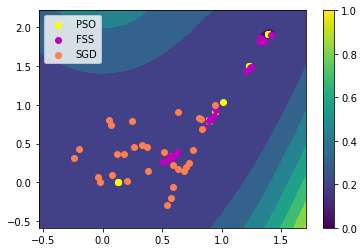

In [24]:
    x = np.linspace(min(x_spo + x_fss + x_sgd) - 0.3, max(x_spo + x_fss + x_sgd) + 0.3)
    y = np.linspace(min(y_spo + y_fss + y_sgd) - 0.3, max(y_spo + y_fss + y_sgd) + 0.3)
    x, y = np.meshgrid(x, y)
    plt.contourf(x, y, noisy_rosenbrock.function(benc)(dim, (x, y)))

    plt.scatter(x_spo, y_spo, label="PSO", c='yellow')
    plt.scatter(x_fss, y_fss, label="FSS", c='m')
    plt.scatter(x_sgd, y_sgd, label="SGD", c='coral')

    plt.legend()
    plt.colorbar()
    plt.show()